In [6]:
!pwd

/content


In [7]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code')
!pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1asBEAN-S2b77S-W1swprmpEcUXwsqzS3/PROYECTO DE GRADO/Code


In [8]:
!pip install plyfile #Libreria para almacenar datos tridimensionales de escáneres 3D. 

In [9]:
from plyfile import PlyData, PlyElement #Libreria para almacenar datos tridimensionales de escáneres 3D. 
import numpy as np
import cv2 #Librería para problemas de visión por computador
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [10]:
plydata = PlyData.read('Data/bunny/reconstruction/bun_zipper_res2.ply')

In [11]:
plydata.elements[0].data
#Al parecer las primeras 3 primeras columnas son las coordenadas x y z del punto, las otras dos no sé que serán (parecen ser confidence e intensity)

array([(-0.036872 , 0.127727,  0.00440925, 0.850855, 0.5),
       (-0.0453607, 0.128854,  0.00114541, 0.900159, 0.5),
       (-0.0690069, 0.151612,  0.0366018 , 0.398443, 0.5), ...,
       (-0.0643695, 0.149877, -0.0298747 , 0.576031, 0.5),
       (-0.0528961, 0.143026, -0.00045591, 0.527807, 0.5),
       (-0.0318636, 0.155275, -0.00893878, 0.5716  , 0.5)],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('confidence', '<f4'), ('intensity', '<f4')])

In [12]:
points = []
for point in plydata.elements[0].data:
    points.append([point[0], point[1], point[2]])
points = np.array(points)
colors = np.zeros_like(points)

In [13]:
plydata2 = PlyData.read('Data/bunny/reconstruction/bun_zipper_res2.ply')

In [14]:
points2 = []
for point in plydata2.elements[0].data:
    points2.append([point[0], point[1], point[2]])
points2 = np.array(points2)
colors = np.zeros_like(points2)

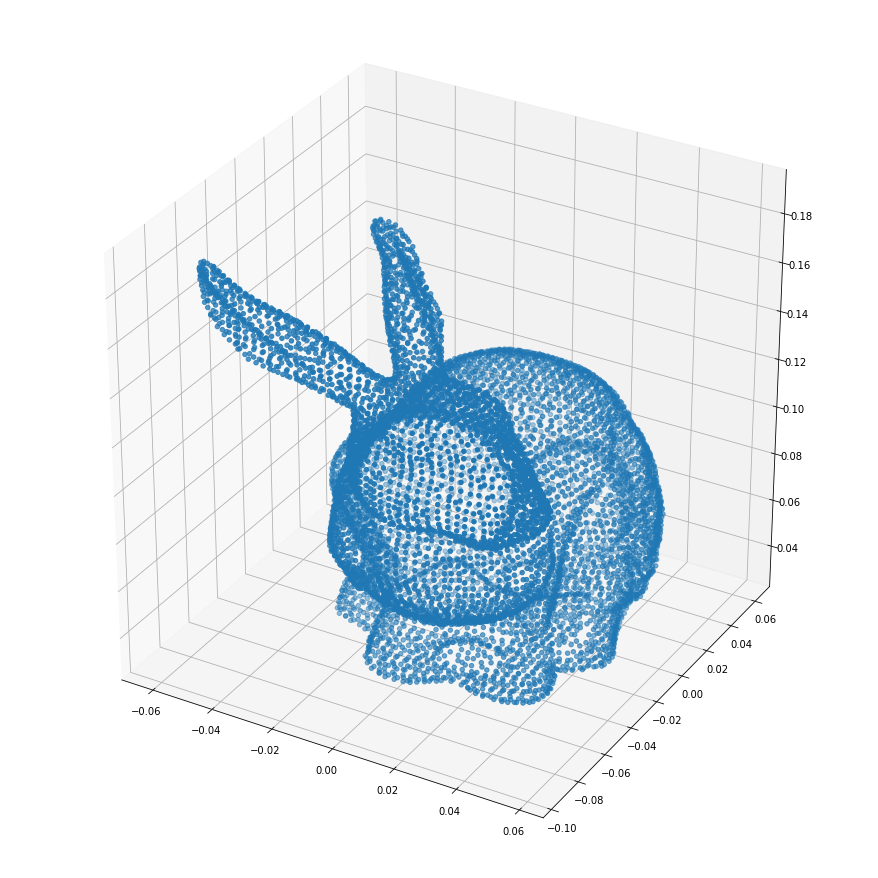

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
v= points
ax = m3d.Axes3D(plt.figure(figsize=(12,12)))
X = v[:,0]
Y = v[:,1]
Z = v[:,2]
ax.scatter3D(Z,X,Y)
plt.show()

In [16]:
from sklearn.neighbors import NearestNeighbors

http://www5.informatik.uni-erlangen.de/Forschung/Publikationen/2005/Zinsser05-PSR.pdf

In [28]:
def rigid_transform(point_cloud_A, point_cloud_B):

  if (point_cloud_A.shape == point_cloud_B.shape): #Verifica que las nubes de puntos tengan la misma dimensión y la misma cantidad de puntos
    
    m = point_cloud_A.shape[1] #m numero de dimensiones
    
    #obtiene los centroides de cada nube de puntos basado en la media de los puntos
    centroid_A = np.mean(point_cloud_A, axis=0)
    centroid_B = np.mean(point_cloud_B, axis=0)

    #Centrando las nubes de puntos a cero (restando su centroide)
    cA = point_cloud_A - centroid_A
    cB = point_cloud_B - centroid_B

    #Matriz de rotacion (Falta buscar la documentacion exacta del proceso)
    H = np.dot(cA.T, (cB.T).T) #plano H
    U, S, Vt = np.linalg.svd(H) #cualquier transformación puede considerarse como una secuencia de rotación (V * ), escala (S) y rotación de nuevo (U)
    R = H #matriz de rotación
    
    # special reflection case (no entiendo :/ ))
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # Traslacion
    t = centroid_B.T - np.dot(R,centroid_A.T) #resta al centroide de B el centroide rotado de A

    #Matriz de transformacion rígida
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t
  else:
    print('Las dimensiones de las nubes de puntos no corresponden o son diferentes' )

  return T


In [18]:
m=5
M = np.identity(m+1)
M[:m,:m] = 5
M[:m,m]=1
M

array([[5., 5., 5., 5., 5., 1.],
       [5., 5., 5., 5., 5., 1.],
       [5., 5., 5., 5., 5., 1.],
       [5., 5., 5., 5., 5., 1.],
       [5., 5., 5., 5., 5., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [19]:
def nearest_neighbor(src, dst):
    #Encuentra el vecino más cercano mediante el método euclidiano
    #src Matriz de puntos origen
    #dst Matriz de puntos destino
    #Retorna las distancias euclidianas del vecino más cercano y sus indices

    if (src.shape == dst.shape): #Verifica que las nubes de puntos tengan la misma dimensión
      
      neigh = NearestNeighbors(n_neighbors=1) #Busca un vecino 
      neigh.fit(dst) #Ajusta el estimador de vecinos más cercanos del conjunto de datos de entrenamiento
      distances, indices = neigh.kneighbors(src, return_distance=True) #Encuentra los K-vecinos de un punto
    
    else:
      print('Las dimensiones de las nubes de puntos no corresponden o son diferentes' )

    
    return distances.ravel(), indices.ravel()

In [26]:
def icp(point_cloud_A, point_cloud_B, init_pose=None, max_iterations=20, tolerance=0.001):
  #Encuentra la transformación de mejor ajuste que asigna los puntos A a los puntos B
  #init_pose:  transformación homogénea (m + 1) x (m + 1)

  T_list=[]
  if (point_cloud_A.shape == point_cloud_B.shape): #Verifica que las nubes de puntos tengan la misma dimensión
    
    m = point_cloud_A.shape[1]#m numero de dimensiones

    # hacer puntos homogéneos, y se coian para mantener los originales
    src = np.ones((m+1,point_cloud_A.shape[0]))
    dst = np.ones((m+1,point_cloud_B.shape[0]))
    src[:m,:] = np.copy(point_cloud_A.T)
    dst[:m,:] = np.copy(point_cloud_B.T)

    #Estimación de pose inicial
    if init_pose is not None:
      src = np.dot(init_pose, src)


    prev_error = 0
    for i in range(max_iterations):
      #encontrar los vecinos más cercanos entre los puntos de origen y destino actuales
      distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

      #calcular la transformación entre los puntos de origen y los puntos de destino más cercanos
      print(src[:m,:].T.shape, dst[:m,indices].T.shape)
      '''
      T = rigid_transform(src[:m,:].T, dst[:m,indices].T)
      T_list.append(T)

      #Actualiza el origen aplicandole la transformacion
      src = np.dot(T, src)

      #error
      mean_error = np.mean(distances)
      if np.abs(prev_error - mean_error) < tolerance:
          break
      prev_error = mean_error

    # calcula la transformacion final
    T = rigid_transform(point_cloud_A, dst[:m,:].T)

      '''
  else:
    print('Las dimensiones de las nubes de puntos no corresponden o son diferentes' )

  return T_list, distances, i

In [21]:
T = rigid_transform(points, points2)

In [22]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta), 0],
                     [np.sin(theta),np.cos(theta), 0],
                     [0,0,1]])

translation=1
rotation=np.pi/2
noise_sigma=0.0001
dim=points.shape[1]
A=np.asarray(points.astype(float))
B=np.asarray(points.astype(float))

# Translate
t = np.random.rand(dim)*translation
B += t
print('Traslación: ',t)

# Rotate
R = rotation_matrix(rotation)
B = np.dot(R, B.T).T
print('Rotación: ',rotation,'\n',R)
# Add noise
B += np.random.randn(points.shape[0], dim) * noise_sigma

Traslación:  [0.72890628 0.54507857 0.70807287]
Rotación:  1.5707963267948966 
 [[ 6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]


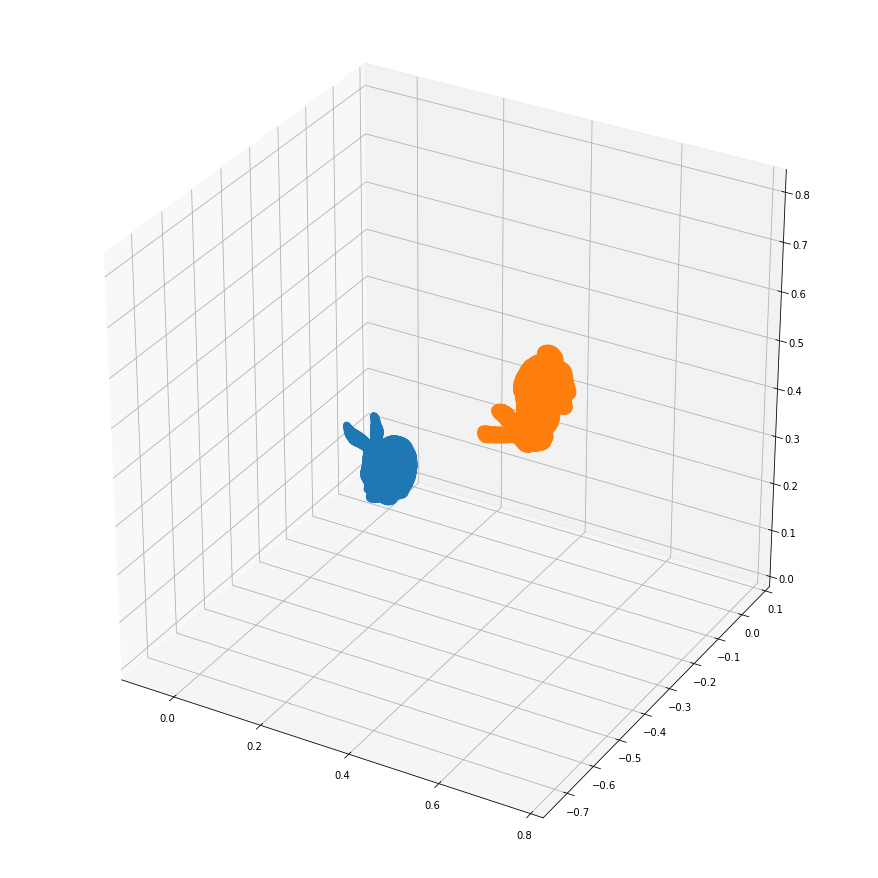

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
v= points
ax = m3d.Axes3D(plt.figure(figsize=(12,12)))
X = A[:,0]
Y = A[:,1]
Z = A[:,2]
ax.scatter3D(Z,X,Y)
X = B[:,0]
Y = B[:,1]
Z = B[:,2]
ax.scatter3D(Z,X,Y)
plt.show()

In [24]:
A.shape

(8171, 3)

In [27]:
#Visualizacion en 3D
T_list, distances, iterations = icp(A, B, max_iterations=20, tolerance=0.001)

for i in range(len(T_list)):
  ax = m3d.Axes3D(plt.figure(figsize=(8,8)))
  #ax.title('Iteration '+str(i))
  ax.scatter(A[:,2],A[:,0],A[:,1],label='original')
  ax.scatter(B[:,2],B[:,0],B[:,1],label='destino')
  Tmp = A + T_list[i][3,:3]
  Tmp = np.dot(T_list[i][:3,:3],Tmp.T).T
  ax.scatter(Tmp[:,2],Tmp[:,0],Tmp[:,1],label='icp')
  #ax.legend()
  plt.show()

(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)
(8171, 3) (8171, 3)


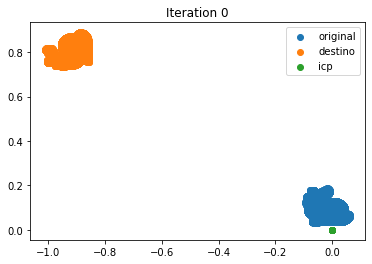

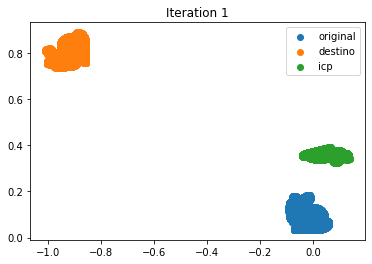

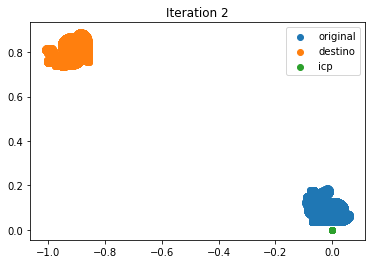

In [105]:
#Visualización en 2D
T_list, distances, iterations = icp(A, B, max_iterations=20, tolerance=0.001)

for i in range(len(T_list)):
  plt.title('Iteration '+str(i))
  plt.scatter(A[:,0],A[:,1],label='original')
  plt.scatter(B[:,0],B[:,1],label='destino')
  Tmp = A[:,:2] + T_list[i][2,:2]
  Tmp = np.dot(T_list[i][:2,:2],Tmp.T).T
  plt.scatter(Tmp[:,0],Tmp[:,1],label='icp')
  plt.legend()
  plt.show()


## Nubes de Puntos (Human Body)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:

!pwd

/content/drive/.shortcut-targets-by-id/1asBEAN-S2b77S-W1swprmpEcUXwsqzS3/PROYECTO DE GRADO/Code


In [23]:
!unzip -u 'Data/torso.zip' -d 'Data/HumanBody'

Archive:  Data/torso.zip


In [24]:
import scipy.io
pc1 = scipy.io.loadmat('Data/HumanBody/torso3_Filtrado.mat')

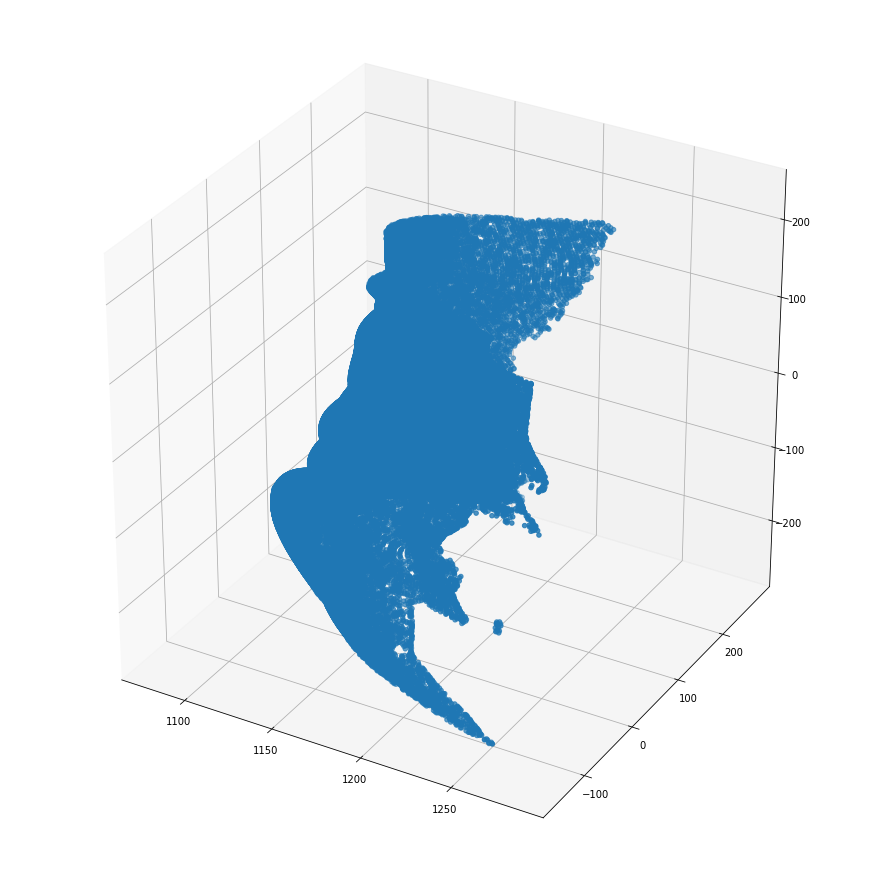

In [25]:
X = pc1['Xc']
Y = pc1['Yc']
Z = pc1['Zc']
ax2 = m3d.Axes3D(plt.figure(figsize=(12,12)))
ax2.scatter3D(Z, X,Y)
plt.show()
pc1 = np.array((X,Y,Z))

In [26]:
pc2 = scipy.io.loadmat('Data/HumanBody/torso2_Filtrado.mat')

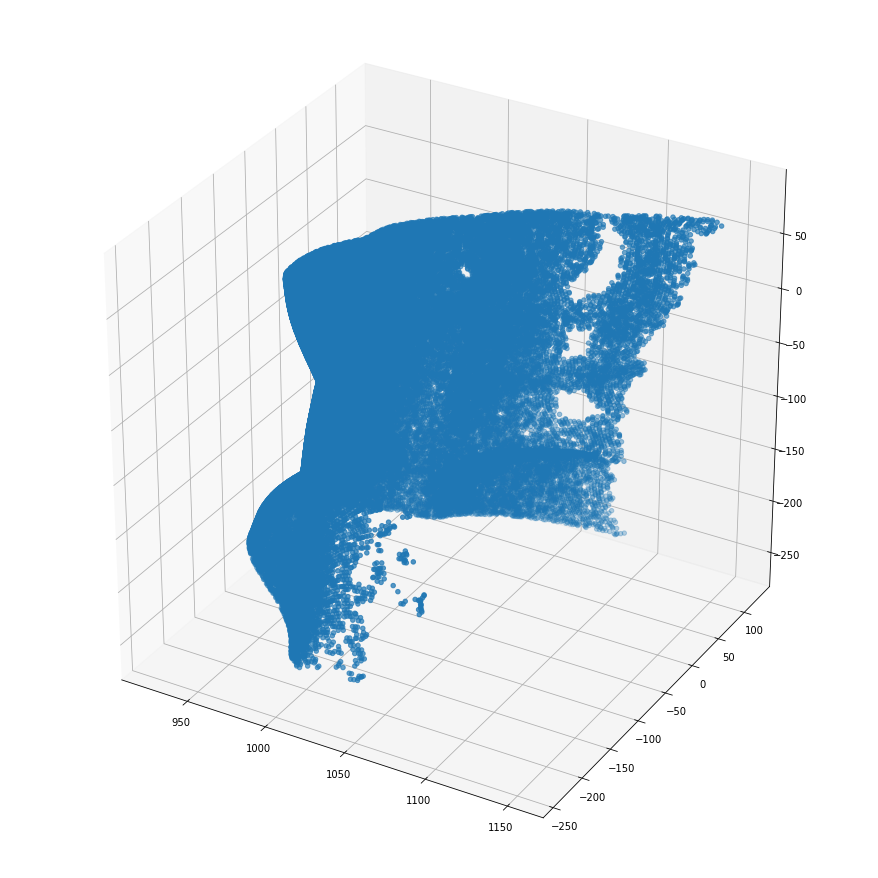

In [27]:
X2 = pc2['Xc']
Y2 = pc2['Yc']
Z2 = pc2['Zc']
ax3 = m3d.Axes3D(plt.figure(figsize=(12,12)))
ax3.scatter3D(Z2,X2,Y2)
plt.show()
pc2 = np.array((X2,Y2,Z2))


In [28]:
pc1.shape

(3, 1, 101605)

In [29]:
pc1=pc1[:,0,:].T
pc2=pc2[:,0,:].T

In [30]:
pc1.shape

(101605, 3)

In [31]:
A=np.asarray(pc1.astype(float))
B=np.asarray(pc2.astype(float))

In [32]:
A.shape

(101605, 3)

In [33]:
B.shape

(68980, 3)

Como se puede observar, las nubes de puntos por obvias razones tienen dimensiones diferentes. Para el algoritmo ICP las nubes de puntos deben tener la misma cantidad de puntos. Por tal razon, a continuación se restringe la nube de puntos 1 al numero de puntos de la nube 2 (68980), con el fin de igualarlas

In [34]:
A_redu= A[0:68980,:]

In [35]:
A_redu.shape

(68980, 3)

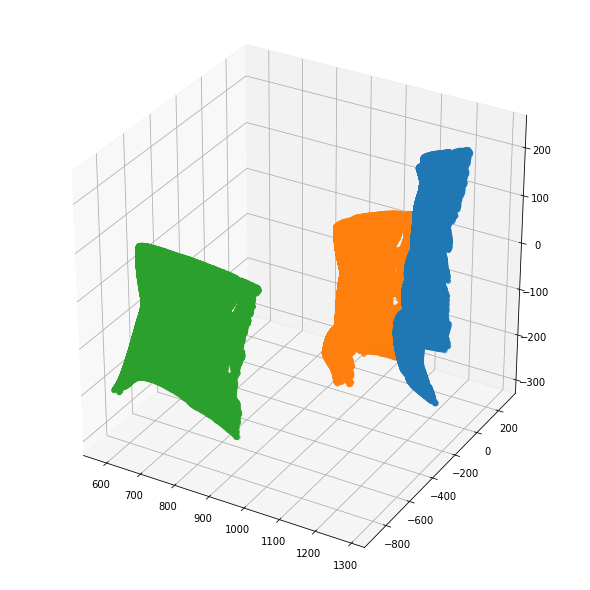

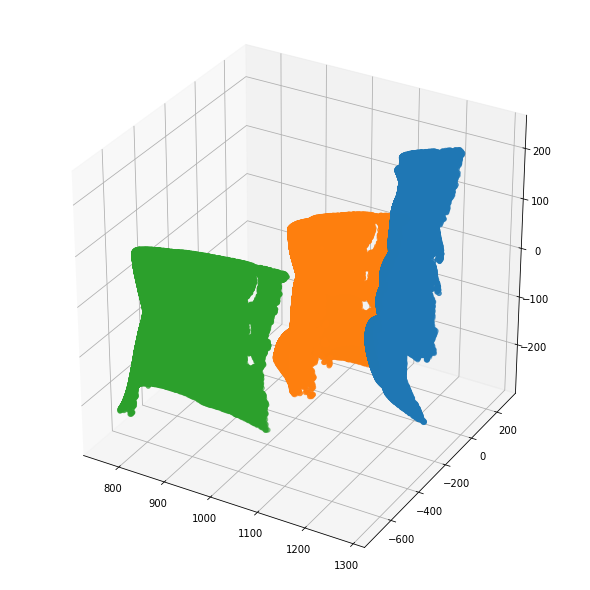

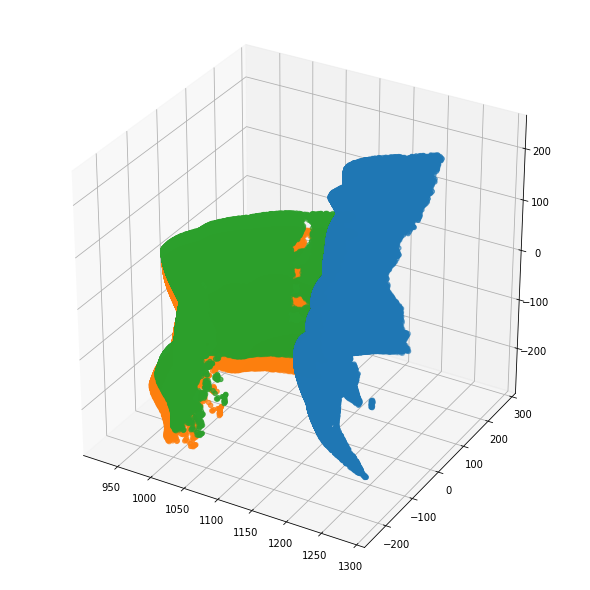

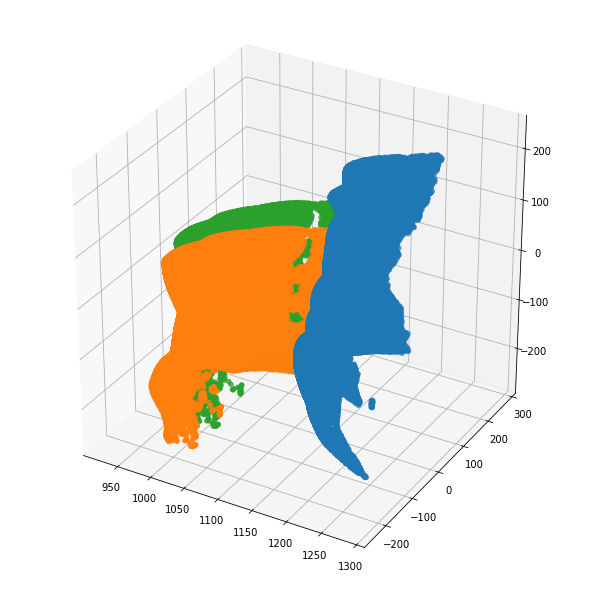

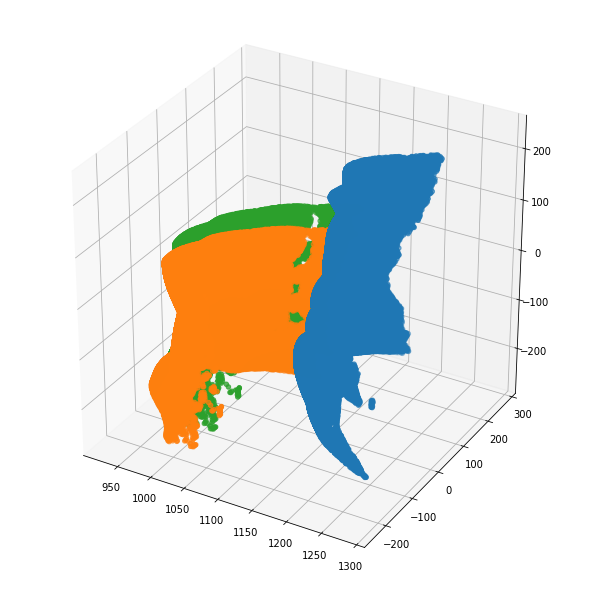

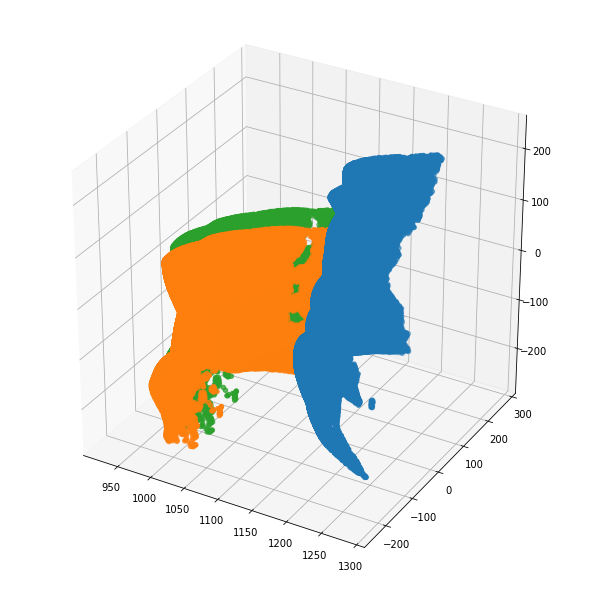

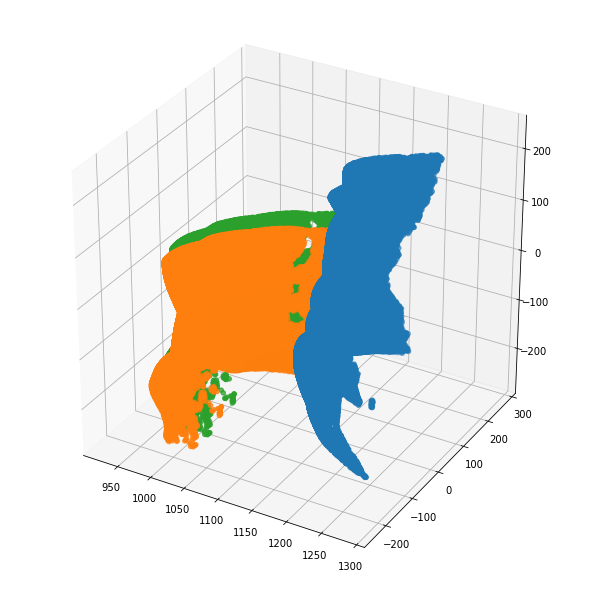

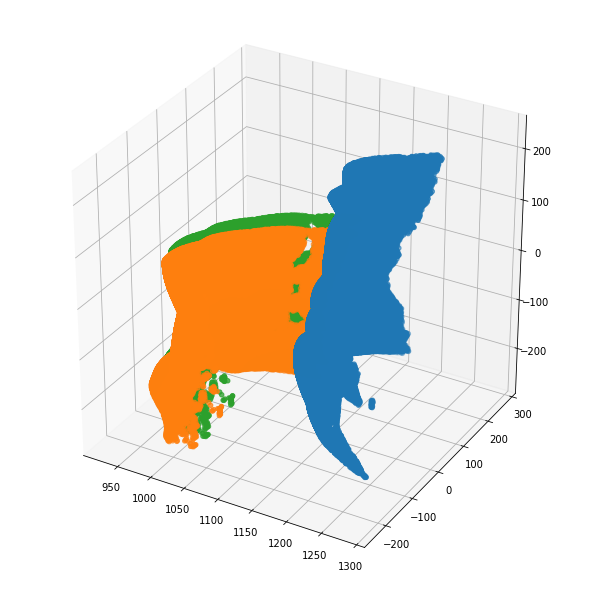

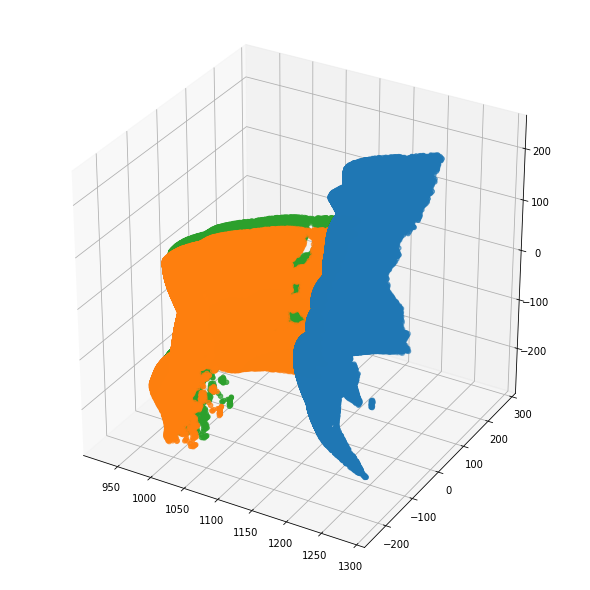

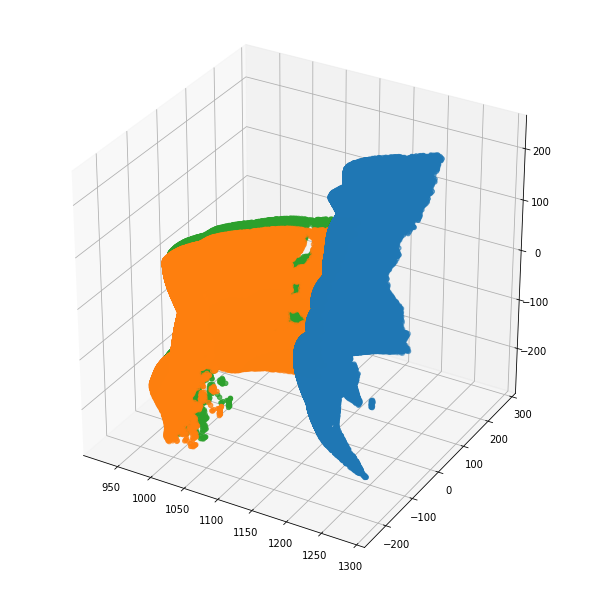

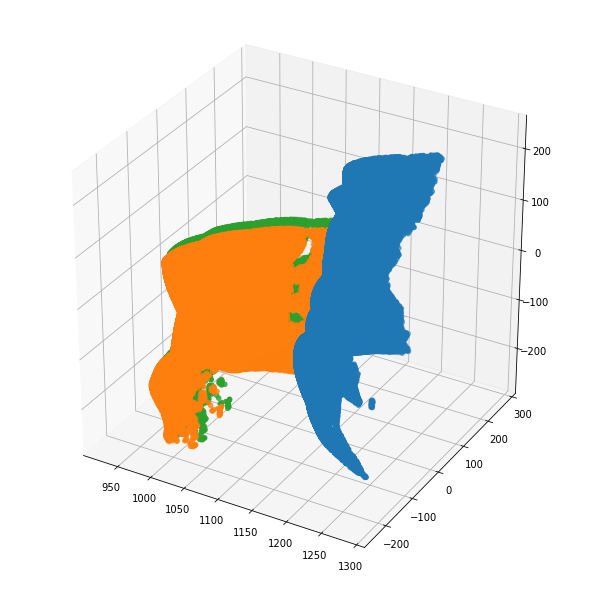

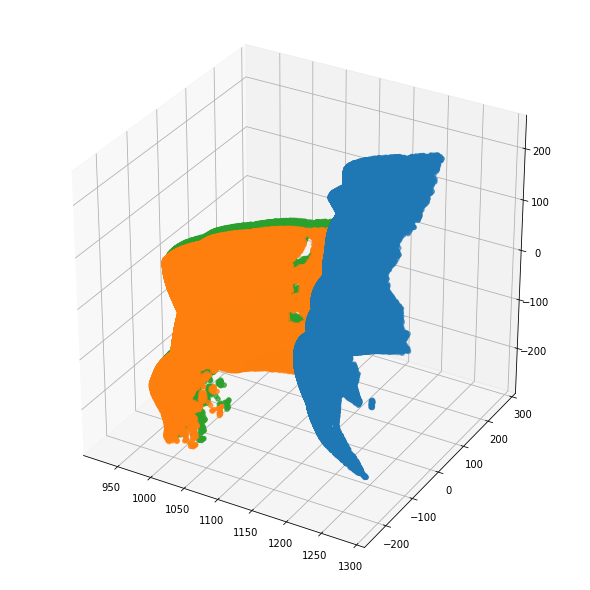

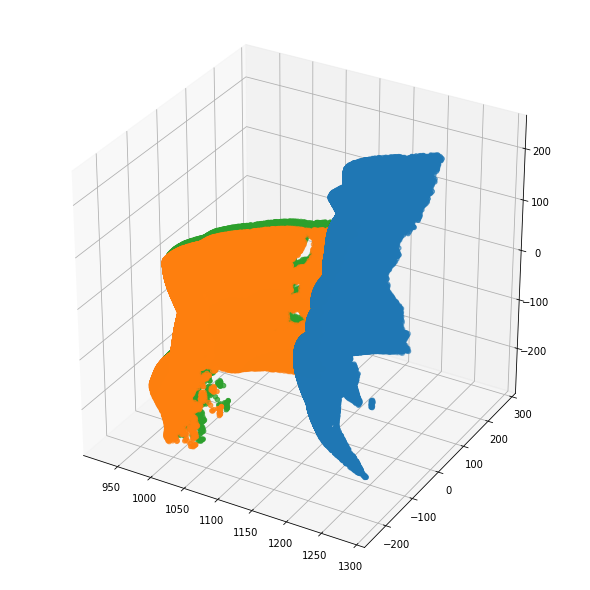

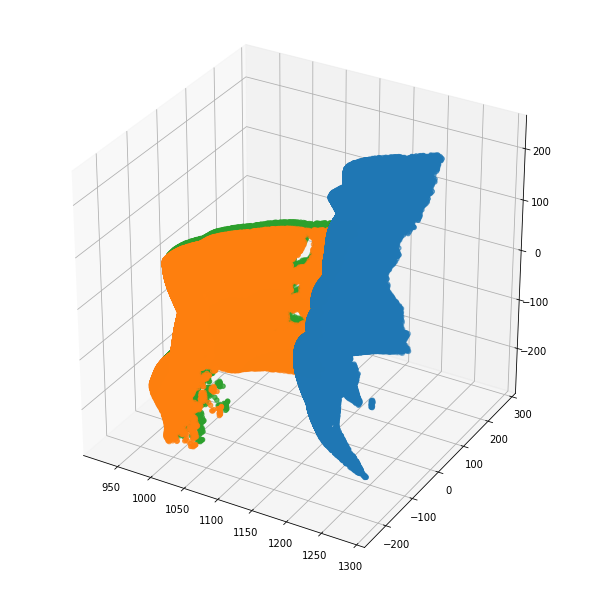

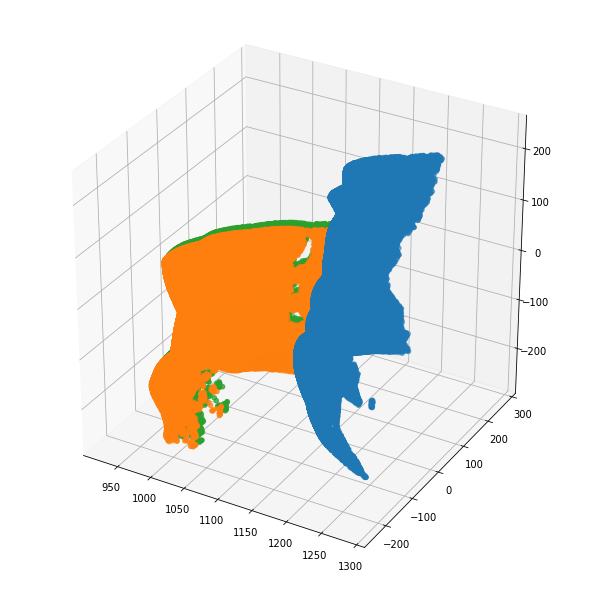

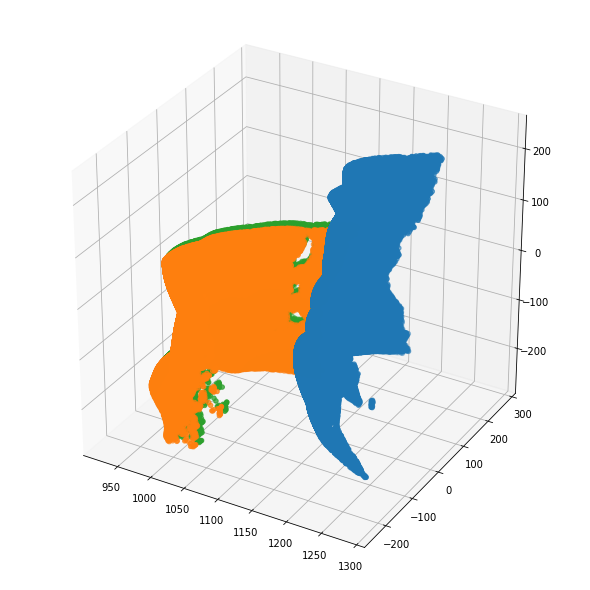

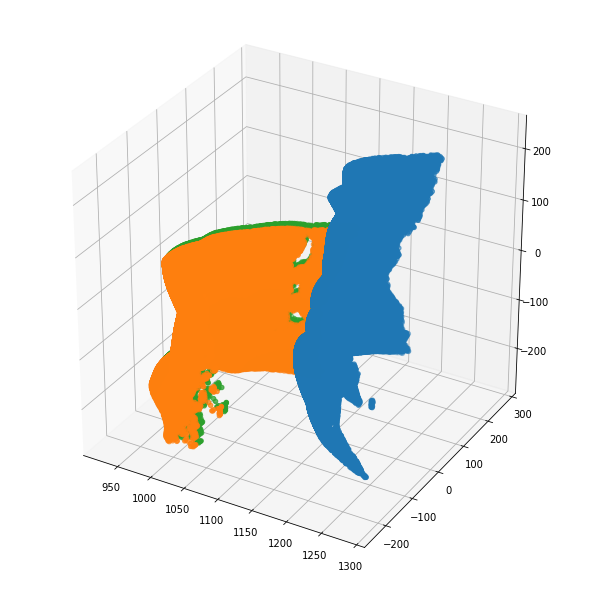

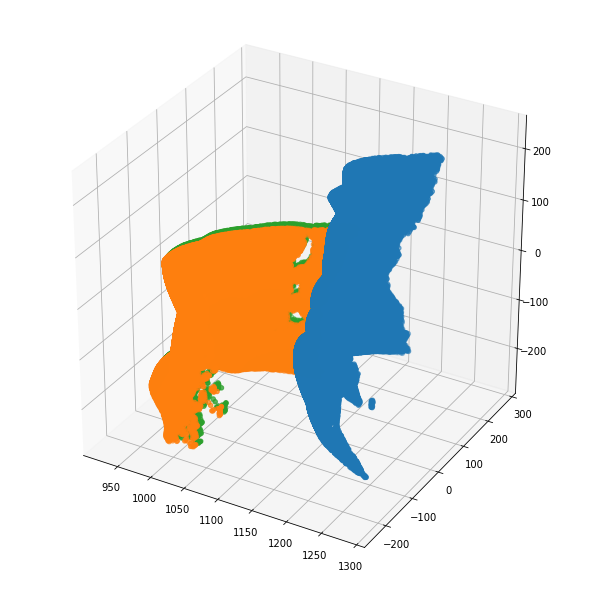

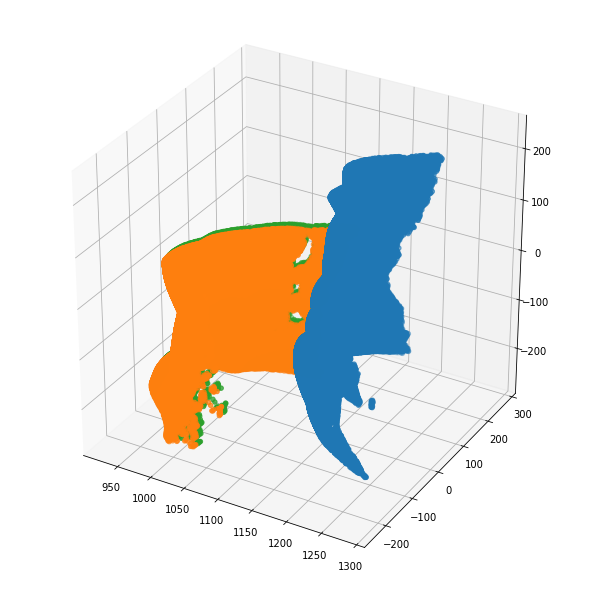

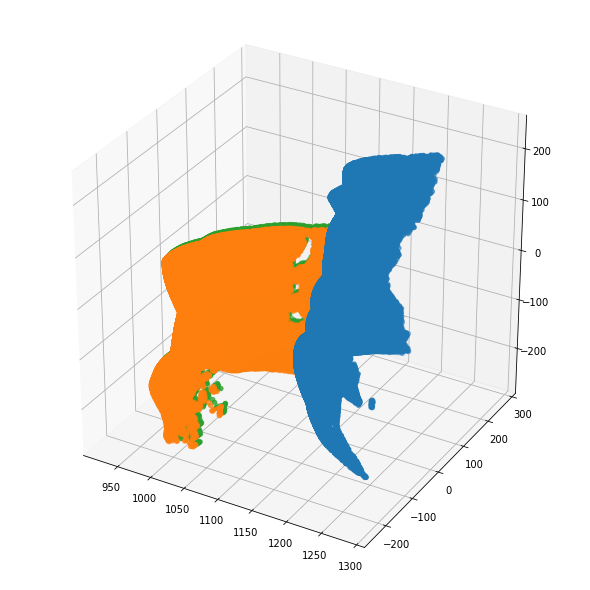

In [36]:
#Visualizacion en 3D
T_list, distances, iterations = icp(A_redu, B, max_iterations=20, tolerance=0.001)

for i in range(len(T_list)):
  ax = m3d.Axes3D(plt.figure(figsize=(8,8)))
  #ax.title('Iteration '+str(i))
  ax.scatter(A[:,2],A[:,0],A[:,1],label='original')
  ax.scatter(B[:,2],B[:,0],B[:,1],label='destino')
  Tmp = B + T_list[i][3,:3]
  Tmp = np.dot(T_list[i][:3,:3],Tmp.T).T
  ax.scatter(Tmp[:,2],Tmp[:,0],Tmp[:,1],label='icp')
  #ax.legend()
  plt.show()

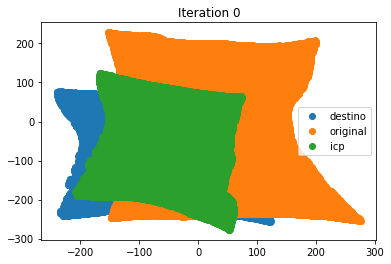

KeyboardInterrupt: ignored

In [37]:
#Visualización en 2D
T_list, distances, iterations = icp(A_redu, B, max_iterations=20, tolerance=0.001)

for i in range(len(T_list)):
  plt.title('Iteration '+str(i))
 
  plt.scatter(B[:,0],B[:,1],label='destino')
  plt.scatter(A[:,0],A[:,1],label='original')
  Tmp = B[:,:2] + T_list[i][2,:2]
  Tmp = np.dot(T_list[i][:2,:2],Tmp.T).T
  plt.scatter(Tmp[:,0],Tmp[:,1],label='icp')
  plt.legend()
  plt.show()

RANSAC
Documentación oficial de opencv

https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#gad767faff73e9cbd8b9d92b955b50062d

In [ ]:
K=np.identity(3)
A_redu=A_redu[:,0:2]
B=B[:,0:2]
print(A.shape)
print(B.shape)
transformation_rigid_matrix, rigid_mask = cv2.estimateAffinePartial2D(A_redu, B,method=cv2.RANSAC)
print(transformation_rigid_matrix)

for i in range(1):
  plt.title('RANSAC')
  plt.scatter(A[:,0],A[:,1],label='original')
  plt.scatter(B[:,0],B[:,1],label='destino')
  Tmp = A + transformation_rigid_matrix[:,2]
  Tmp = np.dot(transformation_rigid_matrix[:,:2],Tmp.T).T
  plt.scatter(Tmp[:,0],Tmp[:,1],label='RANSAC')
  plt.legend()
  plt.show()